In [ ]:
pip install qiskit

In [ ]:
pip install qiskit[visualization]

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

nqubits = 3

beta = Parameter("beta")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw()

┌────────────┐
q_0: ┤ Rx(2*beta) ├
     ├────────────┤
q_1: ┤ Rx(2*beta) ├
     ├────────────┤
q_2: ┤ Rx(2*beta) ├
     └────────────┘

In [ ]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
qc_p.rz(2* gamma,0)
qc_p.rzz(2 * gamma, 1, 2)
qc_p.rz(2*gamma, 1)
qc_p.rz(2*gamma, 2)
qc_p.barrier()

qc_p.decompose().draw()

global phase: -3.0*$\gamma$
     ┌────────────────┐                                          ░ 
q_0: ┤ U1(2*$\gamma$) ├──────────────────────────────────────────░─
     └────────────────┘                       ┌────────────────┐ ░ 
q_1: ────────■─────────────────────────────■──┤ U1(2*$\gamma$) ├─░─
           ┌─┴─┐       ┌────────────────┐┌─┴─┐├────────────────┤ ░ 
q_2: ──────┤ X ├───────┤ Rz(2*$\gamma$) ├┤ X ├┤ U1(2*$\gamma$) ├─░─
           └───┘       └────────────────┘└───┘└────────────────┘ ░

In [ ]:
qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
qc_0.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     └───┘

In [ ]:
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])


qc_qaoa.decompose().decompose().draw()

global phase: -3.0*$\gamma$
     ┌─────────┐┌────────────────┐                                          ░ »
q_0: ┤ U2(0,π) ├┤ U1(2*$\gamma$) ├──────────────────────────────────────────░─»
     ├─────────┤└────────────────┘                       ┌────────────────┐ ░ »
q_1: ┤ U2(0,π) ├────────■─────────────────────────────■──┤ U1(2*$\gamma$) ├─░─»
     ├─────────┤      ┌─┴─┐       ┌────────────────┐┌─┴─┐├────────────────┤ ░ »
q_2: ┤ U2(0,π) ├──────┤ X ├───────┤ Rz(2*$\gamma$) ├┤ X ├┤ U1(2*$\gamma$) ├─░─»
     └─────────┘      └───┘       └────────────────┘└───┘└────────────────┘ ░ »
«     ┌─────────────┐
«q_0: ┤ R(2*beta,0) ├
«     ├─────────────┤
«q_1: ┤ R(2*beta,0) ├
«     ├─────────────┤
«q_2: ┤ R(2*beta,0) ├
«     └─────────────┘

In [ ]:
def compute_expectation(counts):
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = 1
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(theta):
    
    
    nqubits = 6
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        qc.rz(2 * gamma[irep],0)
        qc.rzz(2 * gamma[irep], 1, 2)
        qc.rz(2 * gamma[irep],1)
        qc.rz(2 * gamma[irep],2)
        qc.rz(2 * gamma[irep],3)
        qc.rzz(2 * gamma[irep], 4, 5)
        qc.rz(2 * gamma[irep],4)
        qc.rz(2 * gamma[irep],5)
        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
    #qc.decompose().decompose().draw()
    return qc
print(get_expectation(1))
# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(p, shots=512):
    
    
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        #qc.decompose().decompose().draw()
        return compute_expectation(counts)
    
    return execute_circ

<function get_expectation.<locals>.execute_circ at 0x7f61c88c0cb0>


In [ ]:
from scipy.optimize import minimize


expectation = get_expectation(p=2)

res = minimize(expectation, [1.0, 1.0], method='COBYLA')
res

     fun: 1.0
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 13
  status: 1
 success: True
       x: array([1., 1.])

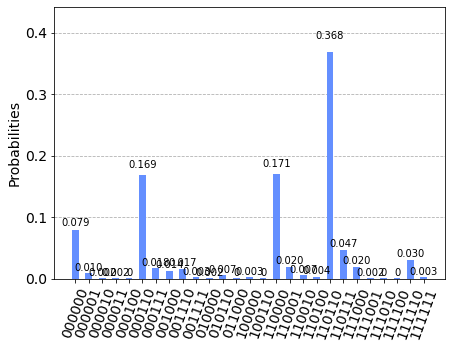

In [ ]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts)